In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from collections import defaultdict
from typing import List, Dict
from typing import Tuple, Any
from torch.nn import MSELoss
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, GraphNode, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, pad_np_vectors
import base_module
from executor import single_train_loop, nested_detach
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging, logging
import logger
import gcn
from gcn import GCNLayer
import transformer
from transformer import TransformerModel
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
reload(gcn)
reload(transformer)
from config import Config
from data import MDataset, Graph, load_graphs
from base_module import MModule
from objects import ModelType
from metric import MetricUtil
from logger import init_logging
from gcn import GCNLayer
from transformer import TransformerModel
init_logging()

datasets_path: /home/yangzichao/repos/DLT-perf-model/datasets
configs_path: /home/yangzichao/repos/DLT-perf-model/notebooks/configs
datasets_path: /home/yangzichao/repos/DLT-perf-model/datasets
configs_path: /home/yangzichao/repos/DLT-perf-model/notebooks/configs


In [3]:
dataset_environment_str = "RTX2080Ti_CPU100"
normalizer_cls = StandardScaler # MinMaxScaler
dummy = False
model_type = ModelType.MLPTestGrouping
method_prefix = "GroupingBased"

In [4]:

eval_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=500_000)
train_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=5_000_000)

[2023-12-06 14:15:58,740] {data.py:331} INFO - Loading graphs train
[2023-12-06 14:15:58,741] {data.py:302} INFO - Loading merged.csv
[2023-12-06 14:15:59,360] {data.py:305} INFO - Loaded merged.csv, 500000 rows
[2023-12-06 14:16:00,233] {data.py:311} INFO - Loaded rand_14500.143_7.csv, 2603 rows
[2023-12-06 14:16:00,493] {data.py:311} INFO - Loaded mnasnet0_75.115_7.csv, 769 rows
[2023-12-06 14:16:00,761] {data.py:311} INFO - Loaded vit_b_16.102_7.csv, 611 rows
[2023-12-06 14:16:03,539] {data.py:311} INFO - Loaded rand_3000.231_7.csv, 8475 rows
[2023-12-06 14:16:04,382] {data.py:311} INFO - Loaded rand_14500.106_7.csv, 2548 rows
[2023-12-06 14:16:04,443] {data.py:311} INFO - Loaded vgg13.38_7.csv, 147 rows
[2023-12-06 14:16:04,704] {data.py:311} INFO - Loaded mnasnet0_75.150_7.csv, 769 rows
[2023-12-06 14:16:04,786] {data.py:311} INFO - Loaded vgg19.66_7.csv, 209 rows
[2023-12-06 14:16:05,071] {data.py:311} INFO - Loaded shufflenet_v2_x1_5.91_7.csv, 847 rows
[2023-12-06 14:16:05,524] 

KeyboardInterrupt: 

56

In [ ]:
train_configs = {
    ModelType.MLPTestGrouping.name: Config.from_dict({
        "model": "MLPTestGrouping",
        "all_seed": 42,
        "dataset_environment_str": dataset_environment_str,
        "dataset_subgraph_grouping_count": 10,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": True,
        "batch_size": 16,
        "eval_steps": 100,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.GCNGrouping.name: Config.from_dict({
        "model": "GCNGrouping",
        "dataset_environment_str": dataset_environment_str,
        "dataset_subgraph_grouping_count": 10,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": True,
        "batch_size": 16,
        "eval_steps": 100,
        "learning_rate": 1e-3,
        "epochs": 100,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
}

conf: Config = train_configs[model_type.name]

In [ ]:
def full_graph_feature(graph: Graph, subgraph_count: int = 10, dataset_params: Dict = {}) -> Tuple[
    Dict[str, np.ndarray], Dict]:
    subgraphs, node_id_to_group_idx = graph.subgraphs(subgraph_count=subgraph_count)

    feature_matrix = list()
    for subgraph in subgraphs:
        subgraph_features = list()
        for node in subgraph:
            node_feature = np.array(node.op.to_feature_array(
                mode=dataset_params.get("mode", "complex")))
            subgraph_features.append(node_feature)
        if len(subgraph_features) == 0:
            feature_matrix.append(np.zeros(1))
            continue
        subgraph_features = pad_np_vectors(subgraph_features)
        feature = np.sum(subgraph_features, axis=0)
        feature = np.append(feature, len(subgraph))
        feature_matrix.append(feature)
    adj_matrix = [
            [0.] * len(subgraphs) for _ in range(len(subgraphs))
    ]
    for curr_idx in range(len(subgraphs)):
        if curr_idx + 1 < len(subgraphs):
            adj_matrix[curr_idx][curr_idx+1] = 1.

    adj_matrix = np.array(adj_matrix)

    # adjacency_matrix = list()
    # for i, subgraph in enumerate(subgraphs):
    #     vector = np.zeros(len(subgraphs) + 1)
    #     for node in subgraph:
    #         neighbor_group_indices = list()
    #         for neighbor in node.neighbors:
    #             neighbor_group_idx = node_id_to_group_idx[neighbor.node_id]
    #             if neighbor_group_idx != i:
    #                 neighbor_group_indices.append(neighbor_group_idx)
    #         for idx in neighbor_group_indices:
    #             vector[idx] = 1
    #     adjacency_matrix.append(vector)

    feature_matrix = pad_np_vectors(feature_matrix)
    feature_matrix = np.array(feature_matrix)
    adj_matrix = np.array(adj_matrix)

    x = {
        "x_graph_id": graph.ID,
        "x_feature_matrix": feature_matrix,
        "x_adjacency_matrix": adj_matrix,
    }
    y = {
        "y_graph_id": graph.ID,
        "y_graph_duration": (graph.graph_duration,)
    }
    return x, y

def init_dataset(graphs: List[Graph]) -> MDataset:
    X = list()
    Y = list()

    feature_matrix_maxsize = 0
    adjacency_matrix_maxsize = 0

    for graph in graphs:
        x, y = full_graph_feature(graph,
                                subgraph_count=conf.dataset_subgraph_grouping_count,
                                dataset_params=conf.dataset_params)
        feature_matrix_size = len(x["x_feature_matrix"][0])
        adjacency_matrix_size = len(x["x_adjacency_matrix"][0])
        feature_matrix_maxsize = max(feature_matrix_maxsize, feature_matrix_size)
        adjacency_matrix_maxsize = max(adjacency_matrix_maxsize, adjacency_matrix_size)

        X.append(x)
        Y.append(y)
    for x in X:
        x["x_feature_matrix"] = pad_np_vectors(x["x_feature_matrix"], maxsize=feature_matrix_maxsize)
        x["x_adjacency_matrix"] = pad_np_vectors(x["x_adjacency_matrix"], maxsize=adjacency_matrix_maxsize)

    dataset = MDataset(X, Y)
    return dataset

train_ds = init_dataset(train_graphs)
eval_ds = init_dataset(eval_graphs)

In [ ]:
def get_scalers(ds: MDataset):
    scaler_cls = conf.dataset_normalizer_cls
    graph_feature_array = list()
    y_array = list()

    for data in ds:
        feature, label = data
        x_feature_matrix = feature["x_feature_matrix"]
        assert isinstance(x_feature_matrix, list)
        graph_feature_array.extend(x_feature_matrix)
        y_array.append(label["y_graph_duration"])

    graph_feature_array = np.array(graph_feature_array)
    y_array = np.array(y_array)

    graph_feature_scaler = scaler_cls()
    graph_feature_scaler.fit(graph_feature_array)

    y_scaler = scaler_cls()
    y_scaler.fit(y_array)
    return graph_feature_scaler, y_scaler

scalers = get_scalers(train_ds)
graph_feature_scaler, y_scaler = scalers


In [ ]:
def preprocess_dataset(ds: MDataset) -> MDataset:
    y_array = list()

    graph_feature_scaler, y_scaler = scalers
    graph_feature_arrays = list()
    for data in ds:
        feature, label = data
        # x. transform for each x feature matrix. do not merge them.
        x_feature_matrix = feature["x_feature_matrix"]
        x_feature_matrix = np.array(x_feature_matrix, dtype=np.float32)
        graph_feature_array = graph_feature_scaler.transform(x_feature_matrix)
        graph_feature_arrays.append(graph_feature_array)
        # y. transform altogether
        y_array.append(label["y_graph_duration"])

    y_array = np.array(y_array, dtype=np.float32)
    y_array = y_scaler.transform(y_array)

    processed_features = list()
    processed_labels = list()
    for i, data in enumerate(ds):
        feature, label = data
        x_adjacency_matrix = np.array(feature["x_adjacency_matrix"], dtype=np.float32)
        processed_features.append({
            "x_graph_id": feature["x_graph_id"],
            "x_feature_matrix": torch.Tensor(graph_feature_arrays[i]),
            "x_adjacency_matrix": torch.Tensor(x_adjacency_matrix)
        })
        processed_labels.append({
            "y_graph_id": label["y_graph_id"],
            "y_graph_duration": torch.Tensor(y_array[i]),
        })

    ds = MDataset(processed_features, processed_labels)
    return ds

preprocessed_train_ds = preprocess_dataset(train_ds)
preprocessed_eval_ds = preprocess_dataset(eval_ds)


In [ ]:

save_dataset_pkl(preprocessed_train_ds, conf.dataset_environment, method_prefix, 'train',
                         conf.dataset_normalization)
save_dataset_pkl(preprocessed_eval_ds, conf.dataset_environment, method_prefix, 'eval',
                         conf.dataset_normalization)
save_scalers_pkl(scalers, conf.dataset_environment, method_prefix, 'train',
                         conf.dataset_normalization)

In [ ]:
preprocessed_train_ds = load_dataset_pkl(conf.dataset_environment, method_prefix, 'train', 
                                         conf.dataset_normalization)
preprocessed_eval_ds = load_dataset_pkl(conf.dataset_environment, method_prefix, 'eval',
                                        conf.dataset_normalization)
scalers = load_scalers_pkl(conf.dataset_environment, method_prefix, 'train',
                           conf.dataset_normalization)
graph_feature_scaler, y_scaler = scalers

Loading dataset RTX2080Ti_CPU100 GroupingBased train Standard
Loading dataset RTX2080Ti_CPU100 GroupingBased eval Standard
Loading scalers RTX2080Ti_CPU100 GroupingBased train, Standard


In [ ]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    batches_len = len(input_batches)

    def compute_graph_duration(_logits):
        _, y_scaler = scalers
        transformed: np.ndarray = y_scaler.inverse_transform(_logits)
        duration_dim = (0, 1)
        durations = transformed[:, duration_dim[0]:duration_dim[1]].sum(axis=1)
        return durations

    graph_id_to_duration_pred = defaultdict(int)
    for idx in range(batches_len):
        inputs = input_batches[idx]
        logits = output_batches[idx]
        logits = nested_detach(logits)
        logits = logits.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        graph_durations = compute_graph_duration(logits)
        for i, graph_id in enumerate(graph_ids):
            graph_duration = graph_durations[i].item()
            graph_id_to_duration_pred[graph_id] = graph_duration
    duration_metrics = MetricUtil.compute_duration_metrics(eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}


In [ ]:

def to_device(conf: Config, features, labels):
    features["x_feature_matrix"] = features["x_feature_matrix"].to(conf.device)
    features["x_adjacency_matrix"] = features["x_adjacency_matrix"].to(conf.device)
    labels["y_graph_duration"] = labels["y_graph_duration"].to(conf.device)
    return features, labels

In [ ]:

class MLPTest_GroupingModel(MModule):

    def __init__(self, input_shape, output_dimension, **kwargs):
        super().__init__(**kwargs)
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features=input_shape[0] * input_shape[1], out_features=128)
        self.output = torch.nn.Linear(128, output_dimension)
        self.loss_fn = MSELoss()

    def forward(self, X):
        X = X["x_feature_matrix"]
        X = self.flatten(X)
        X = self.linear1(X)
        Y = self.output(X)
        return Y

    def compute_loss(self, outputs, Y):
        graph_duration = Y["y_graph_duration"]
        loss = self.loss_fn(outputs, graph_duration)
        return loss


def init_MLPTestGrouping_model() -> MModule | Any:
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    shape = len(sample_x_dict["x_feature_matrix"]), len(sample_x_dict["x_feature_matrix"][0])
    return MLPTest_GroupingModel(input_shape=shape,
                                    output_dimension=len(sample_y_dict["y_graph_duration"]))



In [ ]:


class GCNGroupingModel(MModule):
    def __init__(self, dim_feats, dim_h, y_graph_duration_len, n_layers, dropout):
        super(GCNGroupingModel, self).__init__()
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(GCNLayer(dim_feats, dim_h, F.relu, 0))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(GCNLayer(dim_h, dim_h, F.relu, dropout))
        # output layer
        self.layers.append(GCNLayer(dim_h, y_graph_duration_len, None, dropout))
        self.loss_fn = MSELoss()

    def forward(self, X):
        adj, features = X["x_adjacency_matrix"], X["x_feature_matrix"]
        h = features
        for layer in self.layers:
            h = layer(adj, h)
        graph_duration = torch.sum(h, dim=[1])
        return graph_duration

    def compute_loss(self, outputs, Y) -> torch.Tensor:
        y_graph_duration = Y["y_graph_duration"]
        loss = self.loss_fn(outputs, y_graph_duration)
        return loss


def init_GCNGrouping_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "dim_h": None,
            "n_layers": 2,
            "dropout": 0.1
        }

    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    x_node_feature_size = len(sample_x_dict["x_feature_matrix"][0])
    y_graph_duration_len = len(sample_y_dict["y_graph_duration"])
    model_params = conf.model_params

    final_model_params = default_model_params()
    default_dim_h = x_node_feature_size if final_model_params.get("dim_h") is None else final_model_params.get(
        "dim_h")
    final_model_params["dim_h"] = model_params.get("dim_h", default_dim_h)
    final_model_params["n_layers"] = model_params.get("n_layers", final_model_params["n_layers"])
    final_model_params["dropout"] = model_params.get("dropout", final_model_params["dropout"])
    return GCNGroupingModel(
        dim_feats=x_node_feature_size,
        y_graph_duration_len=y_graph_duration_len,
        **final_model_params
    )


[2023-12-06 14:13:45,008] {executor.py:43} INFO - ModelType.MLPTestGrouping start single training.
[2023-12-06 14:13:45,008] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 0


  0%|          | 0/4 [00:00<?, ?it/s]

[2023-12-06 14:13:45,011] {executor.py:62} INFO - ModelType.MLPTestGrouping trained for 0.00302707 seconds.
[2023-12-06 14:13:45,011] {executor.py:63} INFO - ModelType.MLPTestGrouping eval at step 0.
[2023-12-06 14:13:45,012] {executor.py:67} INFO - ModelType.MLPTestGrouping train loss: 1.0167922973632812, eval metrics: {'eval_loss': 0.25250130891799927, 'MRE': 1.0802255423697342, 'MAE': 0.3366313943415213, 'RMSE': 426333.13029934536}


100%|██████████| 4/4 [00:00<00:00, 572.11it/s]

[2023-12-06 14:13:45,017] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 1



100%|██████████| 4/4 [00:00<00:00, 1058.30it/s]

[2023-12-06 14:13:45,022] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 2



100%|██████████| 4/4 [00:00<00:00, 1160.41it/s]

[2023-12-06 14:13:45,027] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 3



100%|██████████| 4/4 [00:00<00:00, 1114.54it/s]

[2023-12-06 14:13:45,032] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 4



100%|██████████| 4/4 [00:00<00:00, 1197.09it/s]

[2023-12-06 14:13:45,036] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 5



100%|██████████| 4/4 [00:00<00:00, 1211.18it/s]

[2023-12-06 14:13:45,041] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 6



100%|██████████| 4/4 [00:00<00:00, 1188.19it/s]

[2023-12-06 14:13:45,046] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 7



100%|██████████| 4/4 [00:00<00:00, 1215.65it/s]

[2023-12-06 14:13:45,050] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 8



100%|██████████| 4/4 [00:00<00:00, 1165.41it/s]

[2023-12-06 14:13:45,055] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 9



100%|██████████| 4/4 [00:00<00:00, 1174.30it/s]

[2023-12-06 14:13:45,060] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 10



100%|██████████| 4/4 [00:00<00:00, 1199.92it/s]

[2023-12-06 14:13:45,065] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 11



100%|██████████| 4/4 [00:00<00:00, 1189.96it/s]

[2023-12-06 14:13:45,069] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 12



100%|██████████| 4/4 [00:00<00:00, 1212.66it/s]

[2023-12-06 14:13:45,074] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 13



100%|██████████| 4/4 [00:00<00:00, 1211.96it/s]

[2023-12-06 14:13:45,078] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 14



100%|██████████| 4/4 [00:00<00:00, 1156.89it/s]

[2023-12-06 14:13:45,083] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 15



100%|██████████| 4/4 [00:00<00:00, 1187.94it/s]

[2023-12-06 14:13:45,088] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 16



100%|██████████| 4/4 [00:00<00:00, 1157.05it/s]

[2023-12-06 14:13:45,094] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 17



100%|██████████| 4/4 [00:00<00:00, 1168.57it/s]

[2023-12-06 14:13:45,098] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 18



100%|██████████| 4/4 [00:00<00:00, 1203.88it/s]

[2023-12-06 14:13:45,103] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 19



100%|██████████| 4/4 [00:00<00:00, 1209.60it/s]

[2023-12-06 14:13:45,108] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 20



100%|██████████| 4/4 [00:00<00:00, 1151.10it/s]

[2023-12-06 14:13:45,112] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 21



100%|██████████| 4/4 [00:00<00:00, 1275.06it/s]

[2023-12-06 14:13:45,117] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 22



100%|██████████| 4/4 [00:00<00:00, 1224.44it/s]

[2023-12-06 14:13:45,121] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 23



100%|██████████| 4/4 [00:00<00:00, 1229.55it/s]

[2023-12-06 14:13:45,126] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 24



100%|██████████| 4/4 [00:00<00:00, 1210.83it/s]

[2023-12-06 14:13:45,130] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 25



  0%|          | 0/4 [00:00<?, ?it/s]

[2023-12-06 14:13:45,132] {executor.py:62} INFO - ModelType.MLPTestGrouping trained for 0.124690611 seconds.
[2023-12-06 14:13:45,133] {executor.py:63} INFO - ModelType.MLPTestGrouping eval at step 100.
[2023-12-06 14:13:45,134] {executor.py:67} INFO - ModelType.MLPTestGrouping train loss: 0.025290317833423615, eval metrics: {'eval_loss': 0.06677756458520889, 'MRE': 0.6861818274405878, 'MAE': 0.17612018136320268, 'RMSE': 219246.4141156456}


100%|██████████| 4/4 [00:00<00:00, 657.88it/s]

[2023-12-06 14:13:45,138] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 26



100%|██████████| 4/4 [00:00<00:00, 1244.14it/s]

[2023-12-06 14:13:45,142] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 27



100%|██████████| 4/4 [00:00<00:00, 1214.77it/s]

[2023-12-06 14:13:45,147] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 28



100%|██████████| 4/4 [00:00<00:00, 1227.48it/s]

[2023-12-06 14:13:45,151] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 29



100%|██████████| 4/4 [00:00<00:00, 1234.53it/s]

[2023-12-06 14:13:45,156] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 30



100%|██████████| 4/4 [00:00<00:00, 1217.33it/s]

[2023-12-06 14:13:45,160] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 31



100%|██████████| 4/4 [00:00<00:00, 1235.34it/s]

[2023-12-06 14:13:45,165] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 32



100%|██████████| 4/4 [00:00<00:00, 1273.99it/s]

[2023-12-06 14:13:45,169] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 33



100%|██████████| 4/4 [00:00<00:00, 1241.84it/s]

[2023-12-06 14:13:45,174] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 34



100%|██████████| 4/4 [00:00<00:00, 1242.30it/s]

[2023-12-06 14:13:45,178] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 35



100%|██████████| 4/4 [00:00<00:00, 1220.43it/s]

[2023-12-06 14:13:45,182] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 36



100%|██████████| 4/4 [00:00<00:00, 1224.52it/s]

[2023-12-06 14:13:45,187] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 37



100%|██████████| 4/4 [00:00<00:00, 1177.02it/s]

[2023-12-06 14:13:45,192] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 38



100%|██████████| 4/4 [00:00<00:00, 1198.80it/s]

[2023-12-06 14:13:45,196] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 39



100%|██████████| 4/4 [00:00<00:00, 1202.50it/s]

[2023-12-06 14:13:45,201] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 40



100%|██████████| 4/4 [00:00<00:00, 1214.95it/s]

[2023-12-06 14:13:45,205] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 41



100%|██████████| 4/4 [00:00<00:00, 1181.49it/s]

[2023-12-06 14:13:45,210] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 42



100%|██████████| 4/4 [00:00<00:00, 1224.88it/s]

[2023-12-06 14:13:45,215] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 43



100%|██████████| 4/4 [00:00<00:00, 1231.54it/s]

[2023-12-06 14:13:45,219] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 44



100%|██████████| 4/4 [00:00<00:00, 1258.13it/s]

[2023-12-06 14:13:45,223] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 45



100%|██████████| 4/4 [00:00<00:00, 1193.00it/s]

[2023-12-06 14:13:45,228] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 46



100%|██████████| 4/4 [00:00<00:00, 1207.60it/s]

[2023-12-06 14:13:45,232] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 47



100%|██████████| 4/4 [00:00<00:00, 1217.24it/s]

[2023-12-06 14:13:45,237] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 48



100%|██████████| 4/4 [00:00<00:00, 1178.34it/s]

[2023-12-06 14:13:45,242] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 49



100%|██████████| 4/4 [00:00<00:00, 1181.24it/s]

[2023-12-06 14:13:45,246] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 50



  0%|          | 0/4 [00:00<?, ?it/s]

[2023-12-06 14:13:45,248] {executor.py:62} INFO - ModelType.MLPTestGrouping trained for 0.240520373 seconds.
[2023-12-06 14:13:45,249] {executor.py:63} INFO - ModelType.MLPTestGrouping eval at step 200.
[2023-12-06 14:13:45,250] {executor.py:67} INFO - ModelType.MLPTestGrouping train loss: 0.020550590008497238, eval metrics: {'eval_loss': 0.0495164692401886, 'MRE': 0.5243347595991752, 'MAE': 0.15583568042569731, 'RMSE': 188795.66698045176}


100%|██████████| 4/4 [00:00<00:00, 653.32it/s]

[2023-12-06 14:13:45,254] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 51



100%|██████████| 4/4 [00:00<00:00, 1209.60it/s]

[2023-12-06 14:13:45,258] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 52



100%|██████████| 4/4 [00:00<00:00, 1198.37it/s]

[2023-12-06 14:13:45,263] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 53



100%|██████████| 4/4 [00:00<00:00, 1185.84it/s]

[2023-12-06 14:13:45,267] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 54



100%|██████████| 4/4 [00:00<00:00, 1208.56it/s]

[2023-12-06 14:13:45,272] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 55



100%|██████████| 4/4 [00:00<00:00, 1217.77it/s]

[2023-12-06 14:13:45,276] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 56



100%|██████████| 4/4 [00:00<00:00, 1234.71it/s]

[2023-12-06 14:13:45,281] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 57



100%|██████████| 4/4 [00:00<00:00, 1184.83it/s]

[2023-12-06 14:13:45,286] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 58



100%|██████████| 4/4 [00:00<00:00, 1204.65it/s]

[2023-12-06 14:13:45,290] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 59



100%|██████████| 4/4 [00:00<00:00, 1200.95it/s]

[2023-12-06 14:13:45,295] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 60



100%|██████████| 4/4 [00:00<00:00, 1214.07it/s]

[2023-12-06 14:13:45,299] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 61



100%|██████████| 4/4 [00:00<00:00, 1189.54it/s]

[2023-12-06 14:13:45,304] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 62



100%|██████████| 4/4 [00:00<00:00, 1206.39it/s]

[2023-12-06 14:13:45,308] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 63



100%|██████████| 4/4 [00:00<00:00, 1201.38it/s]

[2023-12-06 14:13:45,313] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 64



100%|██████████| 4/4 [00:00<00:00, 1216.18it/s]

[2023-12-06 14:13:45,317] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 65



100%|██████████| 4/4 [00:00<00:00, 1208.38it/s]

[2023-12-06 14:13:45,322] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 66



100%|██████████| 4/4 [00:00<00:00, 1211.88it/s]

[2023-12-06 14:13:45,326] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 67



100%|██████████| 4/4 [00:00<00:00, 1234.07it/s]

[2023-12-06 14:13:45,331] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 68



100%|██████████| 4/4 [00:00<00:00, 1207.52it/s]

[2023-12-06 14:13:45,335] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 69



100%|██████████| 4/4 [00:00<00:00, 1203.36it/s]

[2023-12-06 14:13:45,340] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 70



100%|██████████| 4/4 [00:00<00:00, 1200.09it/s]

[2023-12-06 14:13:45,344] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 71



100%|██████████| 4/4 [00:00<00:00, 1188.36it/s]

[2023-12-06 14:13:45,349] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 72



100%|██████████| 4/4 [00:00<00:00, 1184.00it/s]

[2023-12-06 14:13:45,354] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 73



100%|██████████| 4/4 [00:00<00:00, 1186.84it/s]

[2023-12-06 14:13:45,358] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 74



100%|██████████| 4/4 [00:00<00:00, 1201.72it/s]

[2023-12-06 14:13:45,363] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 75



  0%|          | 0/4 [00:00<?, ?it/s]

[2023-12-06 14:13:45,365] {executor.py:62} INFO - ModelType.MLPTestGrouping trained for 0.356936486 seconds.
[2023-12-06 14:13:45,365] {executor.py:63} INFO - ModelType.MLPTestGrouping eval at step 300.
[2023-12-06 14:13:45,366] {executor.py:67} INFO - ModelType.MLPTestGrouping train loss: 0.03462432324886322, eval metrics: {'eval_loss': 0.11228030920028687, 'MRE': 0.3213087809557331, 'MAE': 0.16842946197520733, 'RMSE': 284294.93540999957}


100%|██████████| 4/4 [00:00<00:00, 653.90it/s]

[2023-12-06 14:13:45,370] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 76



100%|██████████| 4/4 [00:00<00:00, 1188.78it/s]

[2023-12-06 14:13:45,375] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 77



100%|██████████| 4/4 [00:00<00:00, 1192.75it/s]

[2023-12-06 14:13:45,379] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 78



100%|██████████| 4/4 [00:00<00:00, 1187.60it/s]

[2023-12-06 14:13:45,384] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 79



100%|██████████| 4/4 [00:00<00:00, 1214.68it/s]

[2023-12-06 14:13:45,389] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 80



100%|██████████| 4/4 [00:00<00:00, 1195.55it/s]

[2023-12-06 14:13:45,393] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 81



100%|██████████| 4/4 [00:00<00:00, 1230.27it/s]

[2023-12-06 14:13:45,398] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 82



100%|██████████| 4/4 [00:00<00:00, 1216.97it/s]

[2023-12-06 14:13:45,402] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 83



100%|██████████| 4/4 [00:00<00:00, 1218.92it/s]

[2023-12-06 14:13:45,407] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 84



100%|██████████| 4/4 [00:00<00:00, 1206.82it/s]

[2023-12-06 14:13:45,411] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 85



100%|██████████| 4/4 [00:00<00:00, 1219.81it/s]

[2023-12-06 14:13:45,416] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 86



100%|██████████| 4/4 [00:00<00:00, 1214.86it/s]

[2023-12-06 14:13:45,420] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 87



100%|██████████| 4/4 [00:00<00:00, 1209.08it/s]

[2023-12-06 14:13:45,425] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 88



100%|██████████| 4/4 [00:00<00:00, 1213.28it/s]

[2023-12-06 14:13:45,429] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 89



100%|██████████| 4/4 [00:00<00:00, 1208.99it/s]

[2023-12-06 14:13:45,434] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 90



100%|██████████| 4/4 [00:00<00:00, 1205.00it/s]

[2023-12-06 14:13:45,438] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 91



100%|██████████| 4/4 [00:00<00:00, 1216.71it/s]


[2023-12-06 14:13:45,443] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 92


100%|██████████| 4/4 [00:00<00:00, 1215.48it/s]

[2023-12-06 14:13:45,447] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 93



100%|██████████| 4/4 [00:00<00:00, 1220.34it/s]

[2023-12-06 14:13:45,452] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 94



100%|██████████| 4/4 [00:00<00:00, 1219.01it/s]

[2023-12-06 14:13:45,456] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 95



100%|██████████| 4/4 [00:00<00:00, 1215.56it/s]

[2023-12-06 14:13:45,461] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 96



100%|██████████| 4/4 [00:00<00:00, 1210.74it/s]

[2023-12-06 14:13:45,465] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 97



100%|██████████| 4/4 [00:00<00:00, 1191.65it/s]

[2023-12-06 14:13:45,470] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 98



100%|██████████| 4/4 [00:00<00:00, 1200.00it/s]

[2023-12-06 14:13:45,474] {executor.py:45} INFO - ModelType.MLPTestGrouping training epoch 99



100%|██████████| 4/4 [00:00<00:00, 1157.69it/s]


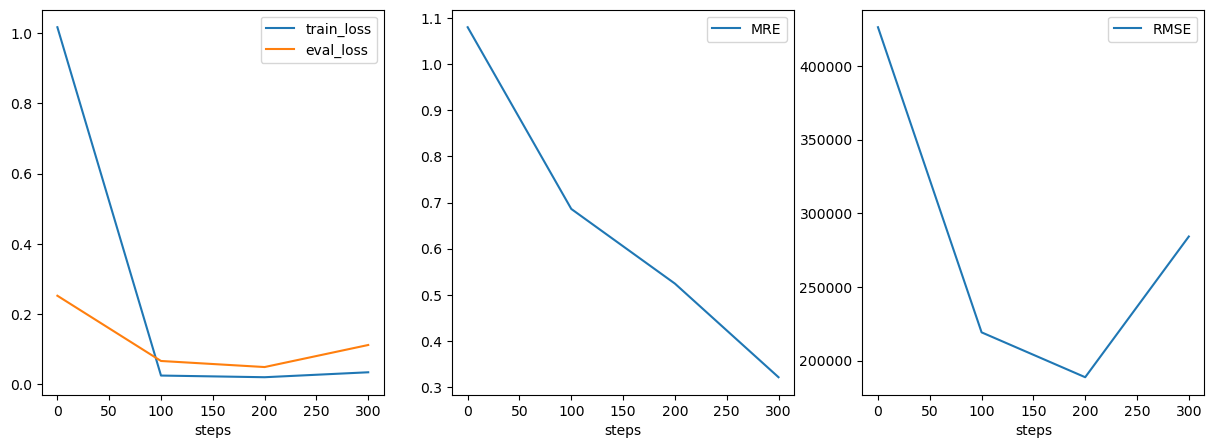

In [ ]:
init_model_funcs = {
    ModelType.MLPTestGrouping.name: init_MLPTestGrouping_model,
    ModelType.GCNGrouping.name: init_GCNGrouping_model,
}

model_type = ModelType.MLPTestGrouping
# model_type = ModelType.GCNGrouping
init_model = init_model_funcs[model_type.name]

model = init_model()
model = model.to(conf.device)

single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)


56
